# Video time segmentation

_Video time segmentation_ is an important data preparation step that can help unlock the full potential of video content for analysis and automation. By breaking down a video into meaningful segments, you can better understand the structure and context of the content, enabling a wide range of applications such as:

* Identifying key events, scenes, or chapters within the video
* Inserting metadata like ad markers or chapter markers
* Reusing relevant clips or segments for new purposes
* Applying advanced analytics and foundation models to specific parts of the video

In this notebook, you'll explore techniques to decompose a video into smaller segments using a combination of audio and visual cues. Specifically, you'll:

* Break down the video into frames, shots, and scenes using visual analysis.
* Extract the audio transcript and identify speech segments, sentences, and topics.
* Combine the audio and visual segmentation to create a comprehensive, multi-modal understanding of the video structure.

By the end of this notebook, you'll have an exploded view of the video content that can serve as a foundation for further analysis, automation, and reuse of the video assets. Let's get started!

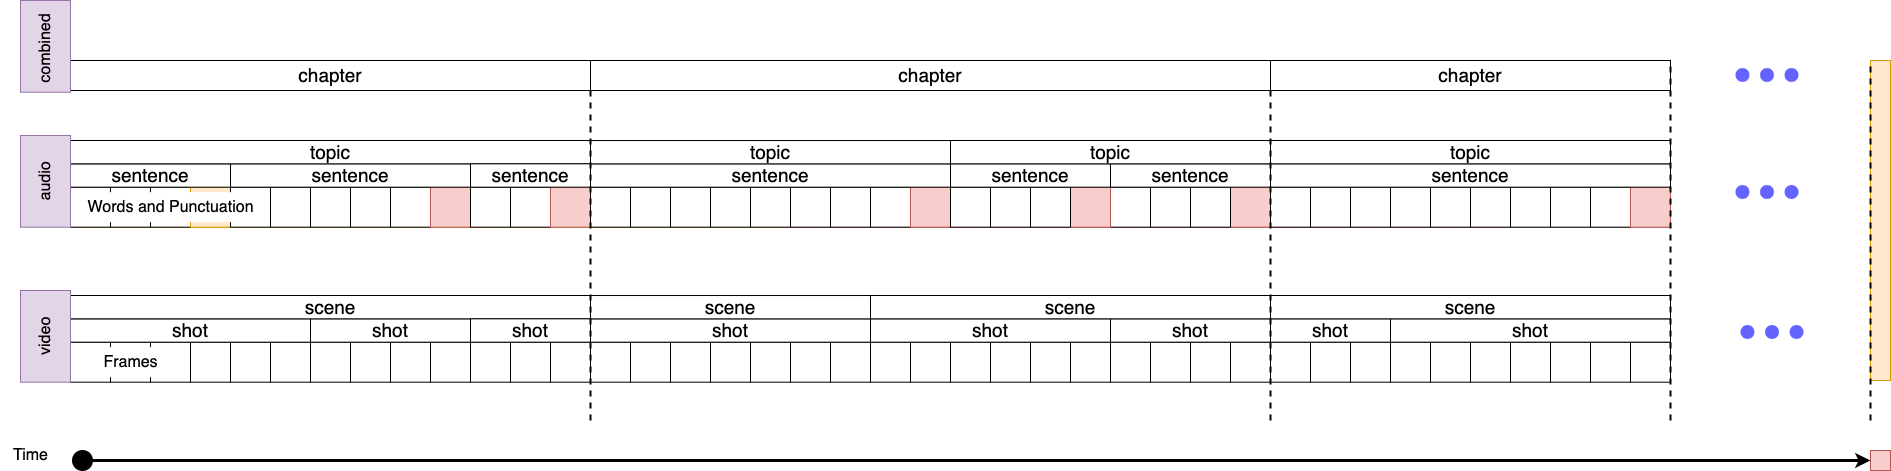
***Figure:** Video file decomposed into time segments*

The outputs of this notebook will be used in the use case sections later on in this workshop.  For example, Ad Break Detection and Contextual Ad Placement, Video Summarization, and more.

<br/><br/>

<div class="alert alert-block alert-info">
💡 In an automated workflow, these audio and video segmentation tasks can be run in parallel since there is no dependency between the steps.
</div>

<div class="alert alert-block alert-info">
💡 Video segmentation can be done along the temporal dimension or along the spatial dimension.  In the context of this notebook, the term “segmentation” will always be <i>time segmentation</i>.
</div>

### Key terms and definitions

You can refer back to this section if you want the definition the terms used in the notebook.

- **Frame** - frame image extracted from the video content
- **Shot** - continuous sequences of frames between two edits or cuts that defines one action
- **Scene** - continuous sequence of action taking place in a specific location and time, consisting of a series of shots.
- **Transcript** - continuous sequence of words and punctuation representing the speech content of the audio track in a video.
- **Sentence** - a full sentence in the English language.
- **Subtitle** - a segment of text representing the speech in a video that is meant to be displayed for viewers as they watch the video.  
- **Conversation topic (aka topic)** - A summarization of a group of sentences that contain discussion about a similar topic.
- **Chapter** - logical divisions of the storyline of the video content, consisting of a series of shots and conversations on the similar topic
- **WebVTT** - a file format used to store timed text track data, such as subtitles or captions, for video content on the web.
- **Frame accurate timestamp** - a timestamp that can be mapped to a specific frame.  Frame accurate timestamps are useful for synchronization of video elements

### Steps

1. Prerequisites
3. Extract frames from the video and create some basic frame metadata
4. Detect shots
5. Detect scenes
6. Convert speech in the video to a text transcript and subtitles
7. Detect sentences in the transcript
8. Detect conversation topics
9. Detect chapters in the video narrative using both visual and audio inputs

<div class="alert alert-block alert-info">
💡 Click on the list icon (<img src="video-understanding-with-generative-ai-on-aws-main/static/icons/list-solid.svg" alt="list icon" width="15" height="15">) in the left navigation panel in this Jupyter notebook to see the outline of the notebook and where you currently are.
</div>

Now, let's build!



## Prerequisites

### Import python packages

In [ ]:
from pathlib import Path
import os
import json
import json
import boto3
import json_repair
from termcolor import colored
from IPython.display import JSON
from IPython.display import Video
from IPython.display import Pretty
from IPython.display import Image as DisplayImage
from lib.frames import VideoFrames
from lib.shots import Shots
from lib.scenes import Scenes
from lib.transcript import Transcript
from lib import util
import requests
from pathlib import Path
from tqdm import tqdm
import subprocess
from typing import Tuple

### Retrieve saved values from previous notebooks

To run this notebook, you need to have run the previous notebook: [00_prerequisites.ipynb](./00-prequisites.ipynb), where you installed package dependencies and gathered some information from the SageMaker environment.

In [ ]:
# Get variables from the previous notebook
%store -r

## Download the sample video, Meridian, from Netflix

The open source content is available under the [Creative Commons Attribution 4.0 International Public License](https://creativecommons.org/licenses/by/4.0/legalcode)

In [ ]:
def download_video(url: str, output_path: str) -> str:
    """
    Download Netflix Meridian test video if not already present
    """
    
    if os.path.exists(output_path):
        print(f"Video already exists at {output_path}")
        return output_path
    
    print("Downloading Netflix Meridian test video...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(output_path, 'wb') as file, tqdm(
        desc=output_path,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            pbar.update(size)
            
    return

In [ ]:
video = {}
video["path"] = 'Netflix_Open_Content_Meridian.mp4'
video["output_dir"] = Path(video["path"]).stem
video["url"] = f"https://dx2y1cac29mt3.cloudfront.net/mp4/netflix/{video['path']}"

download_video(video["url"], video["path"])

Video(url=video["url"], width=640, height=360, html_attributes="controls muted autoplay")

## Frame extraction and Shot segmentation

We prepare visual elements by using similarity analysis of visual embeddings using Amazon Titan Multimodal Embedding (TME) model from Amazon Bedrock. First, we extract video frames at one frame per second with a 392×220 pixel resolution, optimized for visual quality and computational efficiency through numerous experiments. These extracted frames pass to the TME model to generate embeddings capturing visual features and semantics. The embeddings are compared to group visually similar frames into shots. Following are some shot examples:

![Example of frames grouped into shots](./static/images/01-shot-examples.png)

In this process, we sample one frame per second, then employ cosine similarity logic on adjacent frames to group frame images into shots, representing camera shot changes. 

<div class="alert alert-block alert-info">
💡 392×220 pixel resolution is chosen to optimize the number of frames we can present to our chosen Foundation Model, Anthropic Claude Sonnet 3.5, while still retaining the level of detail we need for our use cases.  Different use cases may use higher or lower resolutions for lower cost or higher quality. 
</div>

<div class="alert alert-block alert-info">
💡 One frame per second sampling is a design choice that is suitable for the content used here, but can be adjusted for high-motion, high-frame-rate videos such as sports or more static video such as newsroom footage.
</div>

## Extract frames from the video

You'll be using a Python package, [_VideoFrames_](./lib/frames.py), to work with the video at the frame level.  This package is available on GitHub.  When you call the main method of VideoFrames, it will do the following steps to help prepare the video for frame based analysis with machine learning:

1. Extract frames from the video, sampling at the specified frame rate, and store the resulting images in the folder `./<video name>/frames/`.
2. The resulting frame metadata contains the following attributes for each frame:

* **timestamp_millis** — the timestamp, in milliseconds, where the frame appears in the video.  We'll use this timestamp to related video analysis results back to the video timeline.
* **image_file** — the location of the image in the `frames` folder.
* **id** - the unique frame id

Let's give it a try.

In [ ]:
video["frames"] = VideoFrames(video["path"], session['bucket'], max_res=(392, 220), sample_rate_fps=1, force=False)

In [ ]:
display(JSON(video["frames"].frames[0], root="first frame"))

### Visualize the extracted frames

Next, let's visualize the extracted frames of the video.  

<div class="alert alert-block alert-info">
🤔 Do you notice any visual patterns in the frames? Based on the frames, can you predict how many shots are in the video?
</div>

 


In [ ]:
video['frames'].display_frames(start=0, end=len(video['frames'].frames))

## Shot Detection
As you may recall, a shot is a continuous sequence of frames between two edits or cuts that define one action.  Usually, a shot represents a single camera position, but sometimes shots may contain camera movements such as panning or zooming.  Based on this definition, frames that belong to the same shot should be similar. 

In order to automatically determine where the shots begin and end in the video, we need a way to group similar frames.  In this step, we'll create an embedding for each frame using Amazon Titan Multimodal Embeddings.  Embeddings encode images, text, or both into the same vector space.  Embeddings can be used to cluster these encoded items by similarity.  With embeddings you can implement use cases such as image search, natural language search for images and multi-modal RAG.  We'll be using helper functions in the [lib/frames.py](./lib/frames.py) to accomplish this task.  

The calculated frame embeddings will be added to each frame in the `Frames` object that is stored in the `video` variable.



### Create frame embeddings

Calling the `method make_titan_multimodal_embeddings()` from the `Frames` class will create frame embeddings and store them in the metadata for each frame.

In [ ]:
video['frames'].make_titan_multimodal_embeddings()

Use the next cell to print the metadata for the first video frame and examine the `titan_multimodal_embedding` attribute.   It's a large vector that encodes the content of the frame in the vector space for the `amazon.titan-embed-image-v1` version of the Titan Multimodal Embeddings model.  When we compare this vector with other vectors encoded using the same model version, we can determine if they are similar.

In [ ]:
display(JSON(video["frames"].frames[0], root="first frame"))

Next, lets do some comparisons of the fist few frames using embeddings.  First, let's print a few frames.

In [ ]:
video['frames'].display_frames(start=0, end=4)

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a, b):
    cos_sim = dot(a, b) / (norm(a) * norm(b))
    return cos_sim

Compare the first frame to the second.  As expected, the similarity score is low as these frames are not very similar.

In [ ]:
frms = video['frames'].frames
cosine_similarity(frms[0]['titan_multimodal_embedding'], frms[1]['titan_multimodal_embedding'])

Now, compare the second frame to the third frame.  The similarity score should be higher, since the main difference in these frames is the lettering with the words "Los Angeles 1947".

In [ ]:
cosine_similarity(frms[1]['titan_multimodal_embedding'], frms[2]['titan_multimodal_embedding'])

Finally, compare the third frame to the fourth frame. Will is be lower or higher?

In [ ]:
cosine_similarity(frms[2]['titan_multimodal_embedding'], frms[3]['titan_multimodal_embedding'])

### Detect shots

In this next activity, we'll use the frame embeddings to group similar frames into shots using a pairwise cosine similarity comparison of the embeddings for adjacent frames.  Will apply the same process we did for the first few frames to all the frames.  We'll choose a SIMILARITY_THRESHOLD to if frames are part of the same shot or in different shots.


Execute the code to detect shots in the video.  Based on testing, 0.85 is a good threshold to use for grouping frames for this type of content, but you may need to adjust it to adapt to other use cases.  You can try setting it lower or higher to experiment with the results.

In [ ]:
SIMILARITY_THRESHOLD = 0.85

video["shots"] = Shots(video["frames"], method="SimilarFrames", min_similarity = SIMILARITY_THRESHOLD)

print(f"Number of shots: {len(video['shots'].shots)} from {len(video['frames'].frames)} frames")

Take a moment to look at the metadata for a sample shot from the results.  

In [ ]:
display(JSON(video["shots"].shots[2]))

The `Shots` method creates a set of composite images consisting of the frames in each shot.  We will be using these composite images later on as inputs to Anthropic Claude Sonnet 3 on Amazon Bedrock to generate inferences about what is happening in the shots.  For now, you can examine the resulting composite images to visualize the shots.

You can also go back and adjust the SIMILARITY_THRESHOLD to experiment with how it changes the output.

In [ ]:
# visualize the shots
for counter, shot in enumerate(video["shots"].shots):
    print(f'\nSHOT {counter}: frames {shot["start_frame_id"] } to {shot["end_frame_id"] } =======\n')
    for image_file in shot['composite_images']:
        display(DisplayImage(filename=image_file['file'], height=75))
        #display(Image('image.png', height=400))
    

🤔 As you look through the lists of shots, do you notice any segments that could be improved?  If you do, you might try to identify some tricky situations for video segmentation.  These include:
* Motion of the subject including rolling credits, cars, etc.
* Motion of the camera in the form of panning shots and zooming shots
* Fades and other transition effects

There are more advanced techniques for handling these situations, but for our purposes, this result should work fine.
  
Finally, let's play a couple of adjacent shots and observe how they will look as a video clip.  Play `shot[12]`.  

In [ ]:
start = video['shots'].shots[12]['start_ms']/1000
end = video['shots'].shots[12]['end_ms']/1000
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)

Play `shot[13]`

In [ ]:
start = video['shots'].shots[13]['start_ms']/1000
end = video['shots'].shots[13]['end_ms']/1000
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)

🤔 These shots show two people in the same room having a conversation that spans the shots.  Because these two shots are in the same setting, they belong together into a higher level grouping.  In the next section, we'll group shots together based on the visual information to get a more holistic view of the scene.

## Scene Detection


Even after identifying individual camera shots, there may still be semantically similar shots depicting the same setting. To further cluster these into distinct scenes, we expand frame comparison beyond adjacent frames. By looking at similar frames across an expanded time window, we can identify shots that are likely part of the same contiguous scene. We calculate pairwise similarity scores between all frames within a given time window. Frames with similarity scores above a certain threshold are considered part of the same scene group. This process performs recursively across all frames in a shot. 

<div class="alert alert-block alert-info">
💡 The time window size and similarity threshold are parameters that can significantly impact the accuracy of scene boundary detection. In our example, a 3-minute time window and 0.85 similarity threshold gave the best scene clustering results across our video samples, but this can be adjusted.
</div>

We accomplish scene grouping by first indexing all video frames using TME again and storing the embeddings along with their shot information and timestamps into a vector database, as illustrated in the following figure.

![shots-to-scenes.png](static/images/01-shots-to-scenes.png)

We then perform a recursive similarity search against this indexed frame corpus. For each frame, we find all other frames within a 3-minute time window in both directions with greater than 85% contextual similarity based on their vector representations. The shot information for these highly similar frames is recorded. This process iterates for all frames in a shot to compile contextually similar shots. This process repeats across all shots, and the compiled results look like this example:

    shot 1 –> 2, 3, 4
    shot 2 –> 1, 3
    shot 3 –> 2, 4, 5
    shot 7 –> 8, 9

Finally, we run a reduction process to group shots that are mutually identified as highly similar into distinct scene groups as follows:

    shot 1, 2, 3, 4, 5 → scene 1
    shot 7, 8, 9 → scene 2

This allows us to segment the initially detected shot boundaries into higher-level semantic scene boundaries based on visual and temporal coherence. The end-to-end process is illustrated in the following diagram.

### Populate a FAISS vector store

We will be using a local FAISS vector store to make it easier to search our frame embeddings to find similar frames.  There are a number of different databases on AWS that can be used as a vector store.  One popular choice is Amazon OpenSearch.

In [ ]:
video['frames'].make_vector_store()

### Search for similar frames using the vector store

Let's use the vector store to find similar frames for the second frame in our list.  This the first frame of the introductory sequence that displays the words "Los Angelos 1947".  Based on inspection of the frames, we should get 3 _adjacent_ similar frames.   

Our similarity search function uses a [cosine similarity function](https://en.wikipedia.org/wiki/Cosine_similarity) to determine the [K nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) in the vector space. There are three parameters that you can adjust to tune the result of the similarity search:

* MIN_SIMILARITY is the similarity threshold.  
* TIME_RANGE is the maximum time range to compare frames to from the input frame
* K is the number of nearest neighbors in the vector space to consider

You can try different values of these parameters to get a feel for how the results change with tuning. The frames 0-16 are displayed after this to help visulize  the results.

In [ ]:
MIN_SIMILARITY = .85
TIME_RANGE = 30
K = 20
video['frames'].search_similarity(1, k = K, min_similarity = MIN_SIMILARITY, time_range = TIME_RANGE)

In [ ]:
video['frames'].display_frames(start=0, end=17)

In [ ]:
video['scenes'] = Scenes(video['frames'], video['shots'].shots)

#### Visualize the scenes

Now let's visualize some scenes using the generated composite images. Note that some scenes will have more than one composite image.

<div class="alert alert-block alert-info">
💡 Use the scroll bar in the output box to view the scenes.  Some scenes contain more frames than can fit on a single composite image, so the may be multiple composite images displayed for each scene.
</div>

🤔 Do you think the scenes grouped the shots in a way that makes sense?  Is there anything you would want to change?

In [ ]:
# visualize the scenes
for counter, scene in enumerate(video["scenes"].scenes):
    print(f'\nScene {counter}: frames {scene["start_frame_id"] } to {scene["end_frame_id"] } =======\n')
    for image_file in scene['composite_images']:
        display(DisplayImage(filename=image_file['file'], height=50))
        #display(Image('image.png', height=400))

Finally, let's play a couple of adjacent scenes and observe how they will look as a video clips. As you play the video segments, pay attention to the transition of the _video and the audio_ from one scene to the next.

In [ ]:
start_scene = 9
start = video['scenes'].scenes[start_scene]['start_ms']/1000
end = video['scenes'].scenes[start_scene]['end_ms']/1000
print(f"scene { start_scene } duration: {video['scenes'].scenes[start_scene]['duration_ms']/1000} seconds\n")
print(f"start time: { start } end time: {end} seconds\n")
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)

Play the next scene.

In [ ]:
start_scene = start_scene + 1
start = video['scenes'].scenes[start_scene]['start_ms']/1000
end = video['scenes'].scenes[start_scene]['end_ms']/1000
print(f"scene { start_scene } duration: {video['scenes'].scenes[start_scene]['duration_ms']/1000} seconds\n")
print(f"start time: { start } end time: {end} seconds\n")
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)


🤔 We just played scenes 9 and 10.  You may have noticed that the scene changed on a visual cue when the focus of the video turns towards the beach and the ocean.  _However_, this scene change occurs in the middle of the audio of the police dispatcher speaking over the radio.  If we want to make a cut in the video, we should probably consider not only the visual content but the audio as well. That's exactly where we're headed in the next section.

## Audio segmentation

### Generate a transcript, audio segments and WebVTT subtitles using Amazon Transcribe

In [ ]:
video['transcript'] = Transcript(video["path"], session['bucket'])

In [ ]:
JSON(video['transcript'].__dict__)

In [ ]:
JSON(video['transcript'].transcript)

#### Examine the results from Amazon Transcribe
The response from Amazon Transcribe contains a results dictionary with a transcript that contains a text-only transcript and a collection of items which contain each word and punctuation in the transcript along with a confidence score and timestamp for the item. The response also contains the same transcript formatted as subtitles in either WebVTT or SRT format. Let's take a look at these outputs.

We will be using the WebVTT output for our workflow.

##### Transcript JSON output

The transcript `results` attribute contains several interesting and useful outputs:
* **transcripts** - are a list of alternative text only transcripts for the video.  Our results is only configured to generate 1 alternative, but you can configure Amazon Transcribe to produce more, if needed.  Alternatives are just different semantic interpretations of the speech in the video.
* **items** - items is a time series of `pronunciations` (aka words) and `puntuation` that Amazon Transcribe inferred from the speech in the video.  Because this is AI inference, there is a confidence score for each item. Finally, there is a start and end time for each item, which can use to align timing of the items with other timestamped elements of the video.
* **audio_segments** - audio segments contains a list of sentences or phrases Amazon Transcribe inferred from the Speech in the video. We'll refer to audio segments interchangeably as sentences within this workshop.  Because this is natural language, speech to text doesn't always contain proper sentence, thus the more general term used by Amazon Transcribe.

Take a moment to examine each of these attributes from the sample video below.

In [ ]:
JSON(filename=video['transcript'].transcript_file)

**WebVTT Subtitles**

Let's take a look at the first few lines of the WebVTT formatted subtitles generated by Amazon Transcribe.  WebVTT subtitles can be used in video players to display the speech in the video as text on the screen.

In [ ]:
!head {video['transcript'].vtt_file}

Finally, let's view the video with the generated subtitle track.  Note: we used the shot information to start the video at the shot where the first speech occurs in the video.

In [ ]:
# Play the video with subtitles

from IPython.display import HTML
from base64 import b64encode
start = video['shots'].shots[8]['start_ms']/1000
end = video['shots'].shots[8]['end_ms']/1000
speech_shot_url = f'{video["url"]}#t={start}'

video_html = f"""
<video width="640" height="360" controls>
    <source src="{speech_shot_url}" type="video/mp4">
    <track src="{video['transcript'].vtt_file}" kind="captions" srclang="en" label="English" default>
</video>
"""

HTML(video_html)

So far, you have used fairly basic building blocks such as the structural information in the video from FFmpeg,  similarity of frames, and English language syntax from speech to text processing, to create time based segments of video.  In the next section, you will finally start to perform semantic analysis, or _video understanding_, to create segments using the ideas expressed in the video content.

### Segmentation by conversation topics using Amazon Bedrock

In this next section, you will use generative AI to understand the conversation topics that are occurring over time in the video transcript.  This is a text summarization task that can be performed by several Foundation Models.  

<div class="alert alert-block alert-info">
💡 We'll be using Anthropic Claude Sonnet 3.5 on Amazon Bedrock for this and all the other generative AI tasks throughout this workshop.  We chose Anthropic Claude Sonnet 3.5 because of its flexibility to perform a variety of tasks on multimodal (image and text) inputs.  In practice, you may want to substitute different FMs for different tasks based on your requirements.  For example, you may find that Anthropic Claude Haiku produces adequate results at a lower price points for a specific use case.
</div>

You will pass the transcript to the Anthropic Claude 3 Sonnet model on Amazon Bedrock. The model analyzes the transcript and suggests conversational topic points in a specific JSON format. In the prompt, you specify that each topic should contain a start and end timestamp along with a reason describing the topic. The prompts for the Sonnet model are shown below.  Note that this prompt uses the [Anthropic Claude Messages API](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html):

**System prompt**

```
You are a media operation assistant who analyses movie transcripts in WebVTT 
format and suggest topic points based on the topic changes in the conversations. 
It is important to read the entire transcripts.
```


**Messages**

```
[
    {
        'content': 'Here is the transcripts in <transcript> tag:\n'
                '<transcript>{transcript}\n</transcript>\n',
        'role': 'user'
    },
    {
        'content': 'OK. I got the transcript. What output format?',
        'role': 'assistant'
    },
    {
        'content': 'JSON format. An example of the output:\n'
                '{"topics": [{"start": "00:00:10.000", "end": "00:00:32.000", '
                '"reason": "It appears the topic talks about..."}]}\n',
        'role': 'user'
    },
    {
        'content': '{', 'role': 'assistant'
    }
 ]
```

<div class="alert alert-block alert-info">
❓ <b>Ask Amazon Q Developer</b>: What are the inputs for the Anthropic Claude Messages API?
</div>

#### The code below constructs the prompt for Amazon Bedrock and then calls the Amazon Bedrock API to execute the prompt.

In [ ]:
from lib import bedrock_helper as brh
from lib import util

MODEL_ID = 'anthropic.claude-3-haiku-20240307-v1:0'
MODEL_VER = 'bedrock-2023-05-31'
CLAUDE_PRICING = (0.00025, 0.00125)

def analyze_conversations(vtt_file):

    response = {}
    messages = []

    # transcript
    transcript_message = make_transcript(vtt_file)
    messages.append(transcript_message)

    # output format?
    messages.append({
        'role': 'assistant',
        'content': 'Got the transcript. What output format?'
    })

    # example output
    example_message = make_conversation_example()
    messages.append(example_message)

    # prefill output
    messages.append({
        'role': 'assistant',
        'content': '{'
    })

    ## system prompt to role play
    system = 'You are a media operation assistant who analyses movie transcripts in WebVTT format and suggest topic points based on the topic changes in the conversations. It is important to read the entire transcripts.'

    ## setting up the model params
    model_params = {
        'anthropic_version': MODEL_VER,
        'max_tokens': 4096,
        'temperature': 0.1,
        'top_p': 0.7,
        'top_k': 20,
        'stop_sequences': ['\n\nHuman:'],
        'system': system,
        'messages': messages
    }

    response['model_params'] = model_params
    try:
        response['response'] = brh.inference(model_params)
    except Exception as e:
        print(colored(f"ERR: inference: {str(e)}\n RETRY...", 'red'))
        response['response'] = brh.inference(model_params)
    return response



def make_conversation_example():
    example = {
        'topics': [
            {
                'start': '00:00:10.000',
                'end': '00:00:32.000',
                'reason': 'It appears the topic talks about...'
            }
        ]
    }

    return {
        'role': 'user',
        'content': 'JSON format. An example of the output:\n{0}\n'.format(json.dumps(example))
    }

def make_transcript(vtt_file):
    with open(vtt_file, encoding="utf-8") as f:
        transcript = f.read()
    
    return {
        'role': 'user',
        'content': 'Here is the transcripts in <transcript> tag:\n<transcript>{0}\n</transcript>\n'.format(transcript)
    }

def make_conversation_message(text):
    message = {
        'role': 'user',
        'content': 'No conversation.'
    }

    if text:
        message['content'] = 'Here is the conversation of the scene in <conversation> tag.\n<conversation>\n{0}\n</conversation>\n'.format(text)

    return message

def chapters_to_vtt(chapters, output_file):
    """
      Constructs a webvtt caption file based on the timestamps from the given chapters.
      Args:
         chapters - the topic points
         output_file - output file where the caption webvtt content is stored.
      Returns:
         None
    """
    vtt_lines = 'WEBVTT\n\n'
    for idx, chapter in enumerate(chapters):
        line = f"{idx}\n{chapter['start']} --> {chapter['end']}\n{chapter['reason']}\n"
        vtt_lines = vtt_lines+line

    util.save_to_file(output_file, vtt_lines)
    return

#### Execute the prompt and examine the output

The model will return a result formatted the way that was specified using sample output in the prompt `messages`.  In this case it is a list of topics in the video.  Each topic has:

* **start** - the start time of the topic relative to the start of the video in HH:MM:SS.MS format
* **end** - the start time of the topic relative to the start of the video in HH:MM:SS.MS format
* **reason** - the summary of the conversation in the time range between `start` and `end`

Run the next cells to execute the prompt and look at the resulting topics.

In [ ]:
conversations_response = analyze_conversations(video['transcript'].vtt_file)
video['topics'] = conversations_response['response']['content'][0]['json']['topics']

# show the conversation cost
# conversation_cost = brh.display_conversation_cost(conversations_response['response'])

In [ ]:
display(JSON(video['topics'], root='topics'))

#### Finally, let's take one last look at the actual prompt passed to Anthropic Claude with all the parameters filled in.

The `system` prompt outlines the task and constraints for the Anthropic Claude, while the `messages` part of the prompt, model a conversation with the FM.  

In [ ]:
JSON(conversations_response['model_params'], root='prompt')

### Generate "topic points" 

To ensure the model's output accurately reflects the original transcript, the output JSON is post-processed to merge any overlapping chapter timestamps and align the chapter boundaries with the actual caption timestamps from the WebVTT file. 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from lib import topics
## parse the conversation
#conversations = video['topics']

## merge overlapped conversation timestamps
video['topics'] = topics.merge_topics(video['topics'])

## validate the conversation timestamps against the caption timestamps
captions = topics.parse_webvtt(video['transcript'].vtt_file)
video['topics'] = topics.validate_timestamps(video['topics'], captions)

## save the conversations
util.save_to_file(os.path.join('./Netflix_Open_Content_Meridian', 'topics.json'), video['topics'])

In [ ]:
JSON(video['topics'], root='topics')

#### Visualize the topics
Finally, visualize the topics with the video.  We'll output the chapter summaries as a WebVTT file and play them with the video.

In [ ]:
video['topics_vtt'] = os.path.join(video['frames'].video_asset_dir(), "topics.vtt")
chapters_to_vtt(video['topics'], video['topics_vtt'])

In [ ]:
# Play the video with topic summaries

from IPython.display import HTML
from base64 import b64encode
start = video['shots'].shots[8]['start_ms']/1000
end = video['shots'].shots[8]['end_ms']/1000
speech_shot_url = f'{video["url"]}#t={start}'

video_html = f"""
<video width="640" height="360" controls>
    <source src="{speech_shot_url}" type="video/mp4">
    <track src="{video['topics_vtt']}" kind="captions" srclang="en" label="English" default>
</video>
"""

HTML(video_html)

You just used generative AI to make topic summaries of a video.  Neat trick!

🤔 Can you think of other use cases for summarizing different time segments of audio or video content?
<br></br>
🤔 How would you increase the number of topics found by the Foundation Model?


## What's next?

### Store the video metadata so it can be used in the rest of the workshop.

In [ ]:
%store video

### Continue to the next section of the workshop

In the next sections of the workshop, you will use Geneative AI on Amazon Bedrock to generate contextual metadata about the video segments you created in this part of the workshop.  From here you can proceed to any use case notebook.  

For the in-person workshop, go to the next notebook [Ad break detection and contextual Ad tartgeting](02.ad-breaks-and-contextual-ad-targeting.ipynb).

### References for further learning

* [Media2Cloud Solution V4 Solution Guidance on GitHub](https://github.com/aws-solutions-library-samples/guidance-for-media2cloud-on-aws)
* [Rekognition Video Segmentation API code sample](https://github.com/aws-samples/amazon-rekognition-code-samples/blob/main/rekognition-apis/6-video-segment-detection.ipynb)
* [Amazon Bedrock Workshop](https://github.com/aws-samples/amazon-bedrock-workshop)
